## Reverse Mode Autodifferentiation Explained

This article is my attempt to explain reverse mode autodifferentiation to myself and hopefully to anyone else that finds this useful.

### Why autodifferentiation?

The reason we prefer autodifferentiation over symbolic differentiation is due to its efficiency and simplicity. Instead of writing out explicit derivatives or parsing complex expressions and finding their symbolic derivatives, we can just compute a derivative at a particular value directly with the help of autodifferentiation.

### Evaluation Trace

Before we can start differentiating, we need to create an *evaluation trace*. An evaluation trace essentially shows the order of operations in the form of a graph like the one below:

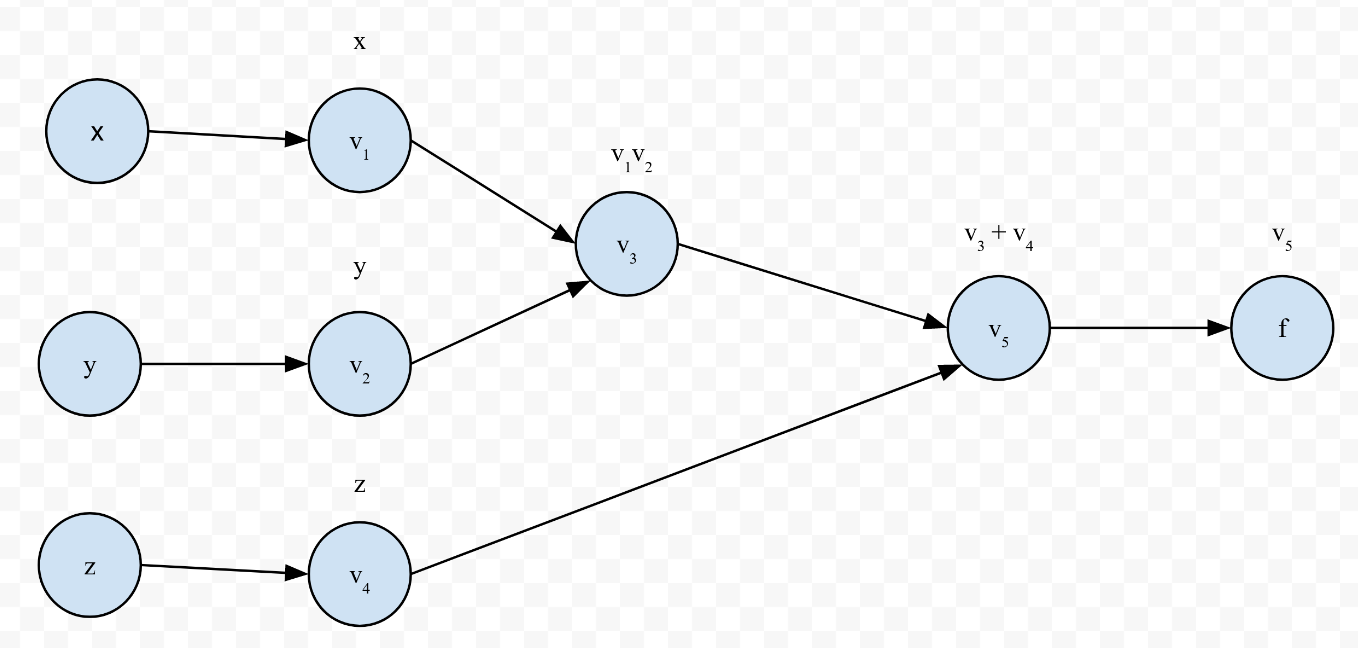

In [60]:
from IPython.display import Image
Image("../assets/img/eval-trace-1.png", width=640, height=180)

This evaluation trace represents the equation $f(x) = xz + y$. The nodes that you see in between the output $f$ and $x, y, z$ are called *intermediate variables*. Now we'll look at how this evaluation trace can be used to compute a derivative.

### Differentiation

This essentially boils down to using the chain rule. To compute $\frac{\partial f}{\partial v_i}$, we do the following:
$$
\begin{align*}
\bar v_i = \frac{\partial f}{\partial v_i} &= \sum_{j \in \text{ children}(i)} \frac{\partial f}{\partial v_j} \frac{\partial v_j}{\partial v_i} \\ &=
\sum_{j \in \text{ children}(i)} \bar v_j \frac{\partial v_j}{\partial v_i}
\end{align*}
$$

Note that since the **children** of $v_i$, $v_j$, are functions of $v_i$ and $f$ is a function of those children, we can apply the chain rule. The $\bar v_i = \frac{\partial f}{\partial v_i}$ and $\bar v_j = \frac{\partial f}{\partial v_j}$ are called *adjoint variables*. We'll use the evaluation trace for the example above to calculate $\frac{\partial f}{\partial x}$. Since $v_1 = x$, we can calculate $\bar v_1$ as follows:
$$
\begin{align}
\frac{\partial f}{\partial v_1} &= \sum_{j \in \text{ children}(1)} \bar v_j \frac{\partial v_j}{\partial v_1} 
\\ &= \bar v_3 \frac{\partial v_3}{\partial v_1}
\end{align}
$$

So to calculate $\bar v_1$, we need to calculate $\bar v_3$. Let's try to calculate $\bar v_3$:
$$
\begin{align}
\frac{\partial f}{\partial v_3} &= \sum_{j \in \text{ children}(3)} \bar v_j \frac{\partial v_j}{\partial v_3} 
\\ &= \bar v_5 \frac{\partial v_5}{\partial v_3}
\end{align}
$$

And now we need to compute $\bar v_5$...but $v_5$'s only child is $f$ and $f = v_5$, so $\frac{\partial f}{\partial v_5} = 1$. So, now we can compute $\bar v_3$! But what about $\frac{\partial v_5}{\partial v_3}$? Well, we know that $v_5 = v_3 + v_4$. Initially, you might think we would try to use some fancy chain rule stuff to programatically do this, but we don't have to. We already know that if $z = x + y$, then $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} = 1$. 
This is a crucial aspect for understanding autodifferentiation: we know how to compute the derivatives of elementary functions, so we can use that to compute $\frac{\partial v_j}{\partial v_i}$ if $v_j$ is a child node of $v_i$. In our example, we know $v_5 = v_3 + v_4$, so we can use our knowledge of differentiating addition to get $\frac{\partial v_5}{\partial v_3} = 1$. If $v_5 = v_4 - v_3$, then we would use our knowledge of differentiating subtraction to get $\frac{\partial v_5}{\partial v_3} = -1$. If $v_5 = e^{v_3}$, then $\frac{\partial v_5}{\partial v_3} = e^{v_3}$. From a programming perspective, this means we need to (1) track which operation is being done and (2) have some way to look up how to compute the gradient of that function. If this doesn't make sense right now, don't worry, we'll write some code that reflects what is happening above.
We now have all the information necessary to compute $\frac{\partial f}{\partial v_3}$:
$$
\begin{align}
\bar v_3 = \frac{\partial f}{\partial v_3} &= \bar v_5 \frac{\partial v_5}{\partial v_3}
\\ &= 1 \cdot 1 \\ &= 1
\end{align}
$$
Also:
$$
\begin{align}
\frac{\partial f}{\partial v_1} &= \bar v_3 \frac{\partial v_3}{\partial v_1}
\\ &= 1 \cdot v_2
\\ &= v_2
\\ &= z
\end{align}
$$
It bears repeating that while we are using symbols to express these derivatives here, when we program this we will be using concrete values for $v_1, v_2, x, $ etc. The procedure above has returned the right answer for $\bar v_1$, since $\frac{\partial f}{\partial v_1} = \frac{\partial}{\partial v_1} (xz + y) = z = v_2$.
Also notice how we computed $\bar v_1$ by first computing $\bar v_5$, then $\bar v_3$, and then finally $\bar v_1$. This is why the procedure is called *reverse*-mode autodifferentiation.

### Code

We will write a small reverse-autodifferentiation program that emulates Pytorch's interface. Namely, we want to be able to do the following:
```python
x = Tensor(3)
y = Tensor(10)
z = x * x + x * y
z.backward()
print(x.grad) # Should print out 2 * 3 + 10 = 16
print(y.grad) # Should print out 3
```

Here's the code below:

In [61]:
def _add_grad_fn(a, b, grad):
    a.grad = grad * 1 if a.grad is None else a.grad + grad * 1
    if a.grad_fn is not None:
        a.grad_fn(*a.inputs, a.grad)
    b.grad = grad * 1 if b.grad is None else b.grad + grad * 1
    if b.grad_fn is not None:
        b.grad_fn(*b.inputs, b.grad)

def _multiply_grad_fn(a, b, grad):
    a.grad = grad * b.value if a.grad is None else a.grad + grad * b.value
    if a.grad_fn is not None:
        a.grad_fn(*a.inputs, a.grad)
    b.grad = grad * a.value if b.grad is None else b.grad + grad * a.value
    if b.grad_fn is not None:
        b.grad_fn(*b.inputs, b.grad)

class Tensor:
    def __init__(self, value, inputs=[], grad_fn=None):
        self.inputs = inputs
        self.value = value
        self.grad = None
        self.grad_fn = grad_fn

    def __add__(self, b):
        return Tensor(self.value + b.value, inputs=[self, b], grad_fn=_add_grad_fn)

    def __mul__(self, b):
        return Tensor(self.value * b.value, inputs=[self, b], grad_fn=_multiply_grad_fn)
    __rmul__ = __mul__

    # This is just to render the tensor as a string
    def __str__(self):
        return f'Tensor({self.value})'
    __repr__ = __str__
        
    def backward(self):
        if self.grad_fn is not None:
            self.grad = 1
            self.grad_fn(*self.inputs, self.grad)
        else:
            raise Exception('grad_fn is None, probably because this tensor isn\'t the result of a computation')

In [62]:
x = Tensor(3)
y = Tensor(10)
z = x * x + x * y
z.backward()
x.grad, y.grad

(16, 3)

Ok, so how does this relate back to what we've seen? First, let's look at the evaluation trace for $z = x \cdot x + x \cdot y$:

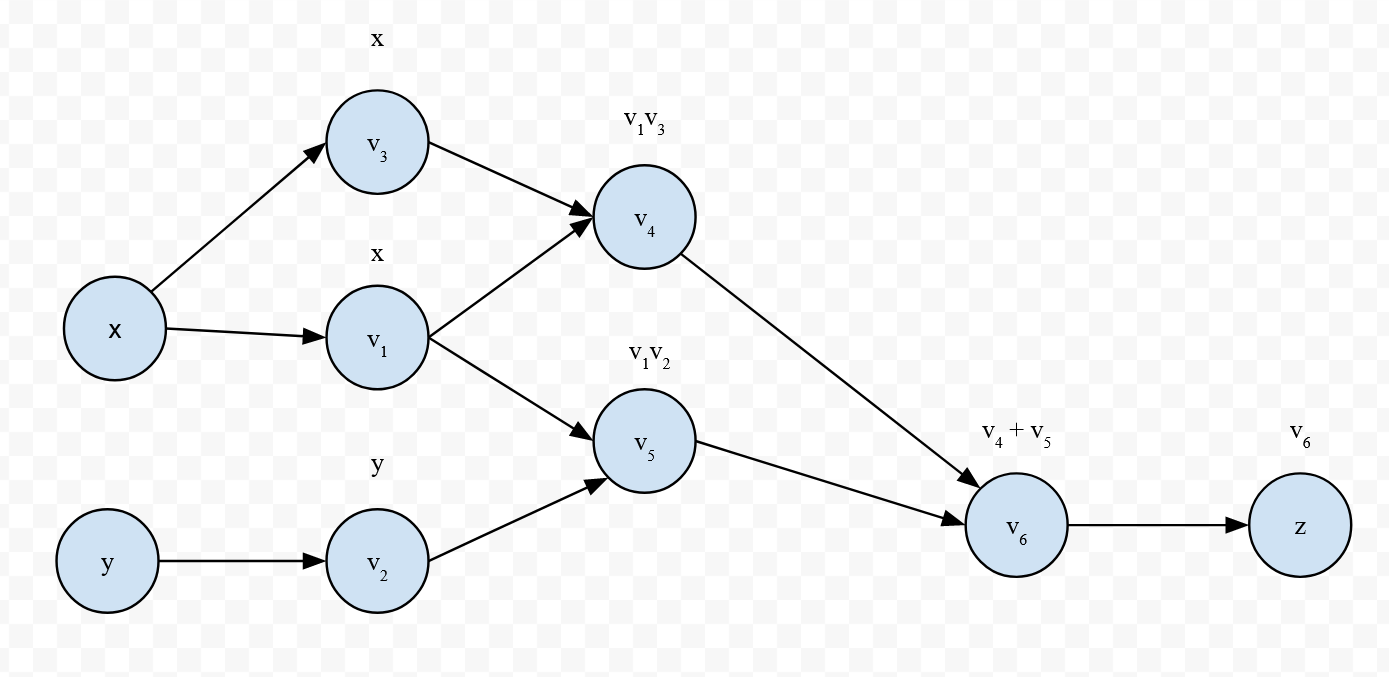

In [63]:
from IPython.display import Image
Image("../assets/img/eval-trace-2.png", width=640, height=180)

Now, we'll step through the code. The key behind this is that each tensor retains its value, a set of inputs that were used to create it (by default, none), a `grad` variable to track the value of its gradient, and a `grad_fn` variable to track a gradient function, which is used to compute the $\frac{\partial v_i}{\partial v_j}$. By default, there is no gradient function, because if I create a tensor (e.g, `x = Tensor(3)`) with only a value, there are no derivatives we can compute (i.e, `x` is a constant, not a function of other variables). Furthermore, the `grad` variable is set to `None` instead of `0` to indicate that no gradient has been computed yet (as `0` could very well be the computed gradient).
> Note that I also use the term "tensor" here. Normally, we would compute these derivatives with respect to a *vector* or *matrix* of values instead of just a single *scalar* like we did above. For simplicity's sake, I decided to keep the code to scalars, but it can be easily extended to vectors, matrices, or tensors if you wish.
 
Let's see what happens when we call `z.backward()`:
```python
def backward(self):
    if self.grad_fn is not None:
        self.grad = 1
        self.grad_fn(*self.inputs, self.grad)
    else:
        raise Exception('grad_fn is None, probably because this tensor isn\'t the result of a computation')
```
We first check that there is a gradient function to call. Assuming there is one, we set the gradient to one and call the gradient function of this tensor. In any computation, the last intermediate variable will always be $1$, since if $v_m$ is the last intermediate variable and $f = v_m$, then $\frac{\partial f}{\partial v_m} = \frac{\partial f}{\partial f} = 1$. In the evaluation trace for $z = x \cdot x + x \cdot y$, $\bar v_6 = 1$. Similarly, for $f(x) = xz + y$, $\bar v_5 = 1$. Following that, we call the current tensor's gradient function, passing in its inputs and its gradient (which is $1$). In the current example, this means passing in $\bar v_6$ (`self.grad`) and $v_4, v_5$ (`self.inputs`). If you're not familiar with Python, the asterisk in `*self.inputs` simply splices the list into the argument list of `self.grad_fn`, so `foo(*[1, 2])` becomes `foo(1, 2)`. 
The gradient function is the core of this. Where is `grad_fn` assigned, you might ask? We overload the multiplication and addition operator for the `Tensor` class so that when we add/multiply two tensors, we get a tensor. This is where we not only set the gradient function to call, but the inputs as well:
```python
def __add__(self, b):
    return Tensor(self.value + b.value, inputs=[self, b], grad_fn=_add_grad_fn)

def __mul__(self, b):
    return Tensor(self.value * b.value, inputs=[self, b], grad_fn=_multiply_grad_fn)
__rmul__ = __mul__
```
Since $z = v_6$ is equal to $v_4 + v_5$, it is the result of an addition, so the `grad_fn` variable points to the `_add_grad_fn` function. Let's look at it:
```python
def _add_grad_fn(a, b, grad):
    a.grad = grad * 1 if a.grad is None else a.grad + grad * 1
    if a.grad_fn is not None:
        a.grad_fn(*a.inputs, a.grad)
    b.grad = grad * 1 if b.grad is None else b.grad + grad * 1
    if b.grad_fn is not None:
        b.grad_fn(*b.inputs, b.grad)
```
Again, `grad` is $\bar v_6 = 1$ right now and `a` and `b` are $v_4$ and $v_5$, respectively. What the gradient function does is compute $\bar v_4$ and $\bar v_5$. Let's look at the computation of `a.grad` and what happens right after. First, we see this peculiar line:
```python
a.grad = grad * 1 if a.grad is None else a.grad + grad * 1
```
If `a.grad` has not been computed yet, then we set it to `grad * 1` because $\bar v_4 = \bar v_6 \frac{\partial v_6}{\partial v_4}$. Since this is addition, $\frac{\partial v_6}{\partial v_4} = 1$ and $\bar v_6 = $ `grad` $ = 1$. However, in the case `a.grad` already has been computed once, why would we do `a.grad = a.grad + grad * 1`? Recall the autodifferentiation equation again:
$$ \bar v_i =  \sum_{j \in \text{ children}(i)} \bar v_j \frac{\partial v_j}{\partial v_i} $$

It is a *sum* over the *children*, but remember that since we are going in reverse, each child will visit its parent once. As an example of this, let's look at $\bar v_1$'s computation:
$$\bar v_1 = \bar v_5 \frac{\partial v_5}{\partial v_1} + \bar v_4 \frac{\partial v_4}{\partial v_1}$$
Since $v_5 = v_1v_2$, it will call `_multiply_grad_fn` and compute $\bar v_1$ and $\bar v_2$, with `grad`=$\bar v_5$ and, since multiplication is an elementary function, we know that $\frac{\partial v_5}{\partial v_1} = v_2$ and $\frac{\partial v_5}{\partial v_2} = v_1$:
```python
a.grad = grad * b.value if a.grad is None else a.grad + grad * b.value
```
In essence, the sum is not performed all at once, but is performed incrementally *as each child visits its parent*. The way we implement each child visiting its parent is through the if statement (which is in both the add and multiply gradient functions):
```python
if a.grad_fn is not None:
        a.grad_fn(*a.inputs, a.grad)
```
Once `grad_fn` is null, we have arrived at a terminal node, so we stop. This is essentially the core of how reverse autodifferentiation works. Note that this implementation uses an *implicit* computational graph, i.e, we do not actually create a graph with nodes and edges to represent the evaluation trace (though you can do this in both Pytorch and Tensorflow). 

If you're still struggling with this, I highly recommend Christopher Bishop's [deep learning book](https://www.bishopbook.com/), specifically the chapter on backpropagation. It gives some more example evaluation traces and gives some performance details regarding both forward and reverse mode autodifferentiation.

### Big Picture
Essentially, reverse mode autodifferentiation works by going backwards through an evaluation trace, and setting/updating the gradients of each adjoint variable it visits until it gets to a terminal node. The code does this traversal implicitly, calling a `grad_fn` which allows it to compute the derivatives of elementary functions, such as addition and multiplication and, as we've seen, it's not hard to write a basic implementation on your own.